In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import pickle

## Configuration

### Rate normalization
Used to get rates in Hz, based on the speed of light, the LHC circumference and the number of bunches

In [4]:
nbunches = 2808.
light = 299792.458
lhc = 27.
rate_normalization = nbunches*light/lhc*1.e-3
print(rate_normalization)

31178.415632


### Plotting styling

In [5]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderTelescopeMSE'] = 'tab:blue'
colors['AutoEncoderStride'] = 'tab:orange'
colors['AutoEncoderQKerasTTbar'] = 'tab:red'
colors['AutoEncoderQKerasEle'] = 'tab:green'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderTelescopeMSE'] = '-'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderQKerasTTbar'] = '--'
styles['AutoEncoderQKerasEle'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderQKerasTTbar'] = 'o'
markers['AutoEncoderQKerasEle'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderTelescopeMSE'] = 'AE Telescope MSE'
legends['AutoEncoderStride'] = 'AE Stride'
legends['AutoEncoderQKerasTTbar'] = 'AE QKeras ttbar'
legends['AutoEncoderQKerasEle'] = 'AE QKeras Ele'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderTelescopeMSE', 
                'AutoEncoderStride',
                'AutoEncoderQKerasTTbar',
                'AutoEncoderQKerasEle',
               ]

### Input files and FE algorithms to be studied
200PU events are loaded. 

These events are preselected with cluster ID applied and keeping only the maximum pT cluster in each event (since single e/g rates are studied).

In [6]:
version = '210430'
fig_dir = '../img/rates_autoencoder_{}'.format(version)
algo_files = {}
# Read first set
directory = '/home/llr/cms/sauvan/DATA_UPG/HGCAL/Dataframes/study_autoencoder/3_22_1/pu_discri_signaldriven/v_1_2021-06-01'
fes = ['Threshold0', 'Threshold', 'Mixedbcstc',
       'AutoEncoderTelescopeMSE', 'AutoEncoderStride',
       'AutoEncoderQKerasTTbar', 'AutoEncoderQKerasEle',]
for fe in fes:
    algo_files[fe] = glob(directory+'/*.hdf5')
    

## Loading dataframes and other data

### Loading L1 $\to$ offline threshold mapping.

In [7]:
with open('../data/mapping_threshold_95eff_autoencoder_{}.pkl'.format(version), 'rb') as f:
    pt_95s = pickle.load(f)

### Loading total numbers of events before preprocessing.

In [8]:
events = {}
for fe,files in algo_files.items():
    evts = 0
    for file in files:
        with open(os.path.splitext(file)[0]+'.txt', 'r') as f:
            lines = f.readlines()
            evts += int(lines[0])
        events[fe] = evts

In [9]:
print(events)

{'Threshold0': 171513, 'Threshold': 171513, 'Mixedbcstc': 171513, 'AutoEncoderTelescopeMSE': 171513, 'AutoEncoderStride': 171513, 'AutoEncoderQKerasTTbar': 171513, 'AutoEncoderQKerasEle': 171513}


### Loading dataframes

In [10]:
algos_dfs = {}
for fe,files in algo_files.items():
    print(fe)
    dfs = []
    for file in files:
        store = pd.HDFStore(file, mode='r')
        df = store[fe]
        df.reset_index(inplace=True)
        store.close()
        dfs.append(df)
    algos_dfs[fe] = pd.concat(dfs)

Threshold0
Threshold
Mixedbcstc
AutoEncoderTelescopeMSE
AutoEncoderStride
AutoEncoderQKerasTTbar
AutoEncoderQKerasEle


## Computing rates

- Sort events in pT
- Build the inverse cumulative distribution (from 1 to 0) (= the rate)
- Do the same after applying the L1 $\to$ offline mapping

In [11]:
rates = {}
rates_rescale = {}
for fe,df in algos_dfs.items(): 
    print(fe)
    tmp = df[df.cl3d_pt_corr > 10]
    tmp['cl3d_pt_95'] = tmp.cl3d_pt_corr.apply(lambda x : np.interp(x, pt_95s[fe].threshold, pt_95s[fe].pt95))
    rate = np.arange(tmp.shape[0]/events[fe], 0., -1./events[fe])
    pts = np.sort(tmp.cl3d_pt_corr)
    rate = rate[rate>1.e-10]
    if pts.shape[0]!=rate.shape[0]:
        raise RuntimeError('Different shapes for pts and rate arrays')
    rates[fe] = (pts, rate)
    rates_rescale[fe] = (np.sort(tmp.cl3d_pt_95), rate)
    

Threshold0


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Threshold


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Mixedbcstc


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AutoEncoderTelescopeMSE


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AutoEncoderStride


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AutoEncoderQKerasTTbar


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AutoEncoderQKerasEle


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Rate as a function of the L1 threshold
Shouldn't be use for comparison since it doesn't take into account the effect of different turnons.

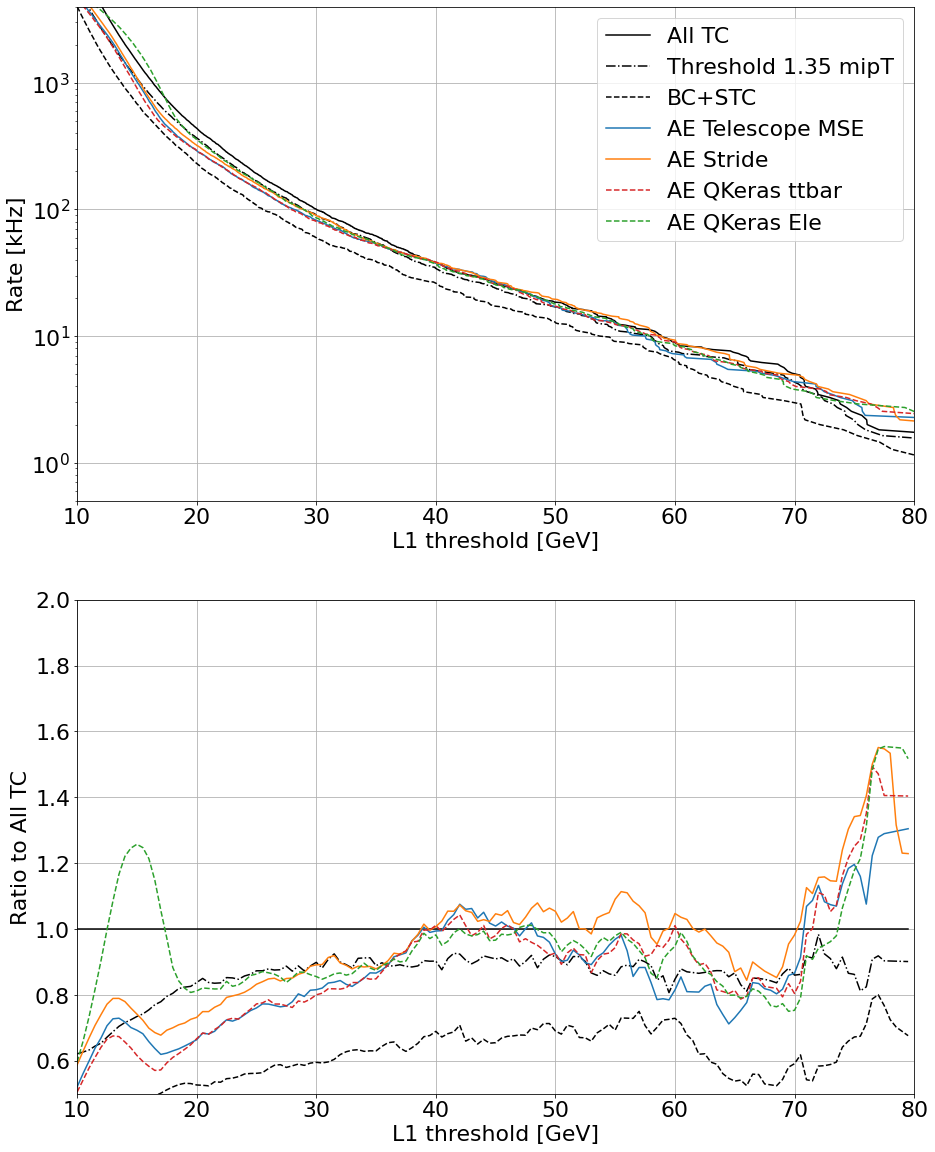

In [12]:
interp_points = np.arange(10, 80, 0.5)
rate_ref = rates['Threshold0']
rate_ref_interp = np.interp(interp_points, rate_ref[0], rate_ref[1])
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
for name in plotted_algo:
    rate = rates[name]
    axs[0].plot(rate[0], rate[1]*rate_normalization, color=colors[name], ls=styles[name], label=legends[name])
    rate_interp = np.interp(interp_points, rate[0], rate[1])
    ratio =  rate_interp / rate_ref_interp
    axs[1].plot(interp_points, ratio, color=colors[name], ls=styles[name], label=legends[name])
axs[0].legend(loc = 'upper right', fontsize=22)
axs[0].set_yscale('log')
axs[0].set_xlim(10, 80)
axs[0].set_ylim(0.5, 4e3)
axs[0].grid()
axs[0].set_xlabel('L1 threshold [GeV]')
axs[0].set_ylabel('Rate [kHz]')
axs[1].set_ylim(0.5, 2)
axs[1].set_xlim(10, 80)
axs[1].set_xlabel('L1 threshold [GeV]')
axs[1].set_ylabel('Ratio to All TC')
axs[1].grid()
plt.show()

Conversion of the previous plot into an impact on the threshold: for a given reference threshold (using Threshold0 option), the plot provides the threshold reduction or increase that would provide the same rate.

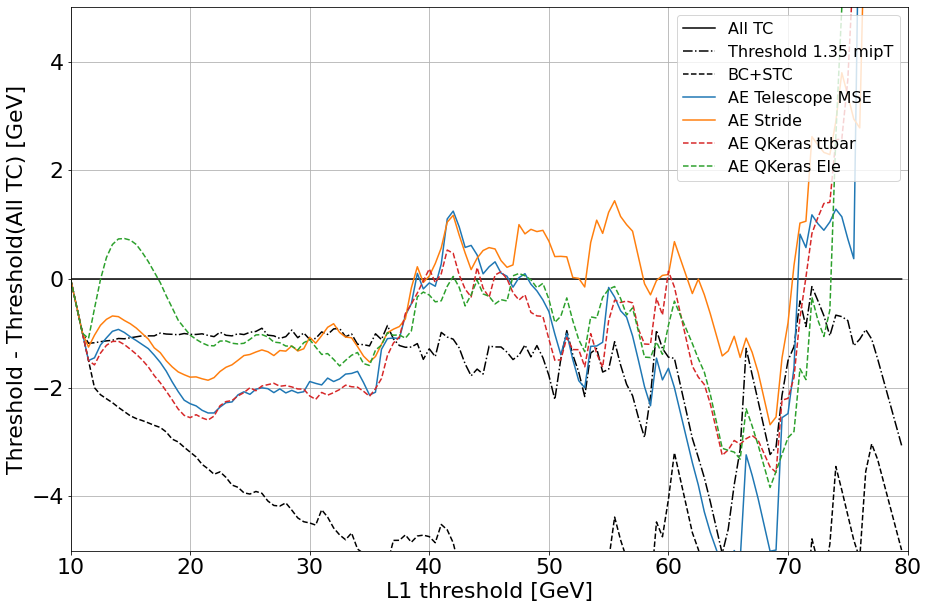

In [13]:
interp_points = np.arange(10, 80, 0.5)
rate_ref = rates['Threshold0']
rate_ref_interp = np.interp(interp_points, rate_ref[0], rate_ref[1])
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
for name in plotted_algo:
    rate = rates[name]
    threshold_interp = np.interp(rate_ref_interp, rate[1][::-1], rate[0][::-1])
    threshold_diff =  threshold_interp - interp_points
    plt.plot(interp_points, threshold_diff, color=colors[name], ls=styles[name], label=legends[name])
plt.legend(loc = 'upper right', fontsize=16)
plt.ylim(-5, 5)
plt.xlim(10, 80)
plt.xlabel('L1 threshold [GeV]')
plt.ylabel('Threshold - Threshold(All TC) [GeV]')
plt.grid()
plt.show()

### Rate as a function of the offline threshold
This is the final plot to be used to compare algorithms

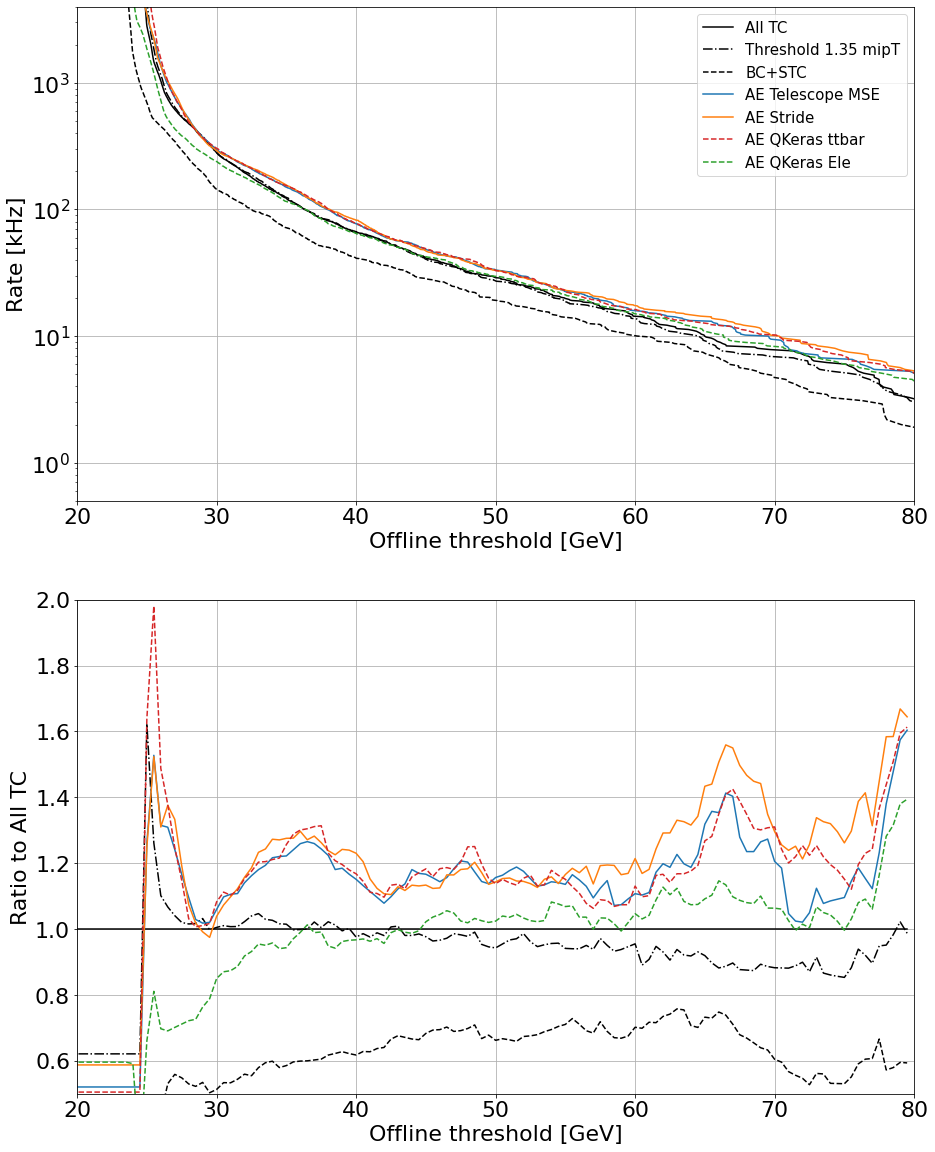

In [14]:
interp_points = np.arange(10, 80, 0.5)
rate_ref = rates_rescale['Threshold0']
rate_ref_interp = np.interp(interp_points, rate_ref[0], rate_ref[1])
matplotlib.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2, 1, figsize=(15,20))
for name in plotted_algo:
    rate = rates_rescale[name]
    axs[0].plot(rate[0], rate[1]*rate_normalization, color=colors[name], ls=styles[name], label=legends[name])
    rate_interp = np.interp(interp_points, rate[0], rate[1])
    ratio =  rate_interp / rate_ref_interp
    axs[1].plot(interp_points, ratio, color=colors[name], ls=styles[name], label=legends[name])
axs[0].legend(loc = 'upper right', fontsize=15)
axs[0].set_yscale('log')
axs[0].set_xlim(20, 80)
axs[0].set_ylim(0.5, 4e3)
axs[0].grid()
axs[0].set_xlabel('Offline threshold [GeV]')
axs[0].set_ylabel('Rate [kHz]')
axs[1].set_ylim(0.5, 2)
axs[1].set_xlim(20, 80)
axs[1].set_xlabel('Offline threshold [GeV]')
axs[1].set_ylabel('Ratio to All TC')
axs[1].grid()
plt.show()

Conversion of the previous plot into an impact on the threshold: for a given reference threshold (using Threshold0 option), the plot provides the threshold reduction or increase that would provide the same rate.

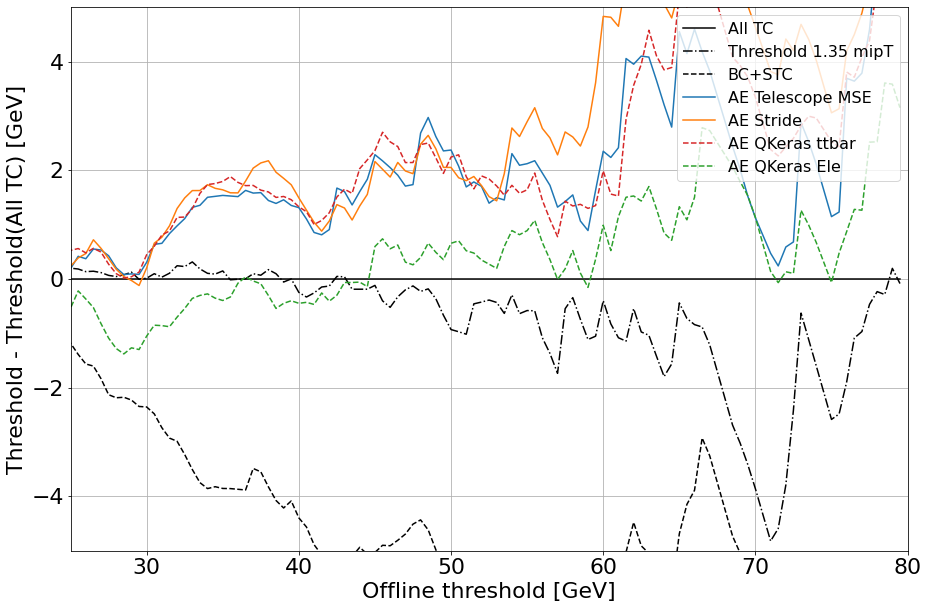

In [15]:
interp_points = np.arange(10, 80, 0.5)
rate_ref = rates_rescale['Threshold0']
rate_ref_interp = np.interp(interp_points, rate_ref[0], rate_ref[1])
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,10))
for name in plotted_algo:
    rate = rates_rescale[name]
    threshold_interp = np.interp(rate_ref_interp, rate[1][::-1], rate[0][::-1])
    threshold_diff =  threshold_interp - interp_points
    plt.plot(interp_points, threshold_diff, color=colors[name], ls=styles[name], label=legends[name])
plt.legend(loc = 'upper right', fontsize=16)
plt.ylim(-5, 5)
plt.xlim(25, 80)
plt.xlabel('Offline threshold [GeV]')
plt.ylabel('Threshold - Threshold(All TC) [GeV]')
plt.grid()
plt.show()

## Additional material
The cells below are a copy of a study based on previous AE network alternatives. The code has not been updated, and is just here for reference.

The goal was to look at the correlation between the AE complexity (NFLOPS) with the rate perfomance, as well as the correlation between the performance in terms of EMD and the rate performance.

In [16]:
summary_algos = [
                'AutoEncoderNominal443',
                'AutoEncoder8x8c4pool',
                'AutoEncoder8x8c6pool',
                'AutoEncoder8x8c8pool',
                'AutoEncoderSepConv443pool',
                'AutoEncoderSepConv663c2',
                'AutoEncoderSepConv663c4pool',
                'AutoEncoderSepConv663c8pool',
               ]
interp_points = np.arange(30, 50, 0.5)
rate_ref = rates_rescale['Threshold']
rate_ref_interp = np.interp(interp_points, rate_ref[0], rate_ref[1])
differences = {}
average_perf = {}
rms_perf = {}
min_perf = {}
max_perf = {}
average_perf_abs = {}
for name in summary_algos:
    rate = rates_rescale[name]
    rate_interp = np.interp(interp_points, rate[0], rate[1])
    difference =  (rate_interp - rate_ref_interp) / rate_ref_interp
    differences[name] = difference
    average_perf[name] = np.mean(difference)
    rms_perf[name] = np.std(difference)
    min_perf[name] = np.min(difference)
    max_perf[name] = np.max(difference)
    average_perf_abs[name] = np.mean(rate_interp)

KeyError: 'AutoEncoderNominal443'

In [17]:
nflops_ratio = {
    'AutoEncoderNominal443':1.,
    'AutoEncoder8x8c4pool':0.64,
    'AutoEncoder8x8c6pool':0.97,
    'AutoEncoder8x8c8pool':0.97,
    'AutoEncoderSepConv443pool':0.97,
    'AutoEncoderSepConv663c2':0.44,
    'AutoEncoderSepConv663c4pool':0.48,
    'AutoEncoderSepConv663c8pool':0.97,    
}
emd_avg = {
    'AutoEncoderNominal443':2.058,
    'AutoEncoder8x8c4pool':1.441,
    'AutoEncoder8x8c6pool':1.234,
    'AutoEncoder8x8c8pool':1.213,
    'AutoEncoderSepConv443pool':1.726,
    'AutoEncoderSepConv663c2':1.854,
    'AutoEncoderSepConv663c4pool':1.591,
    'AutoEncoderSepConv663c8pool':1.239,    
}
#summary = {'name':[], 'perf':[], 'nflops':[]}



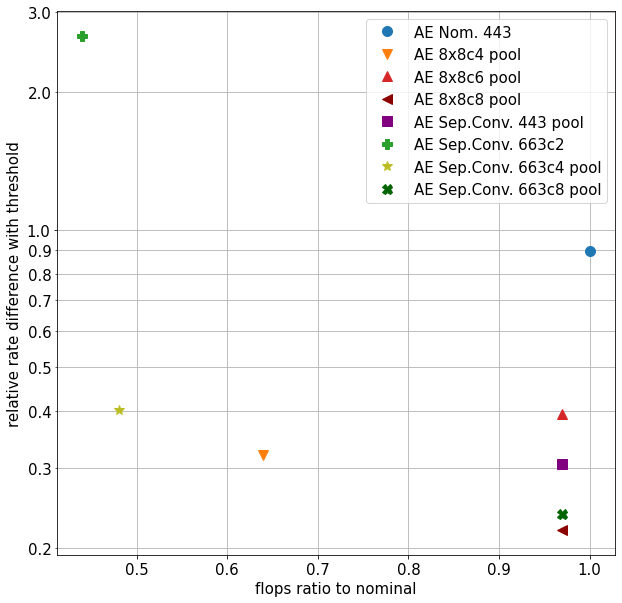

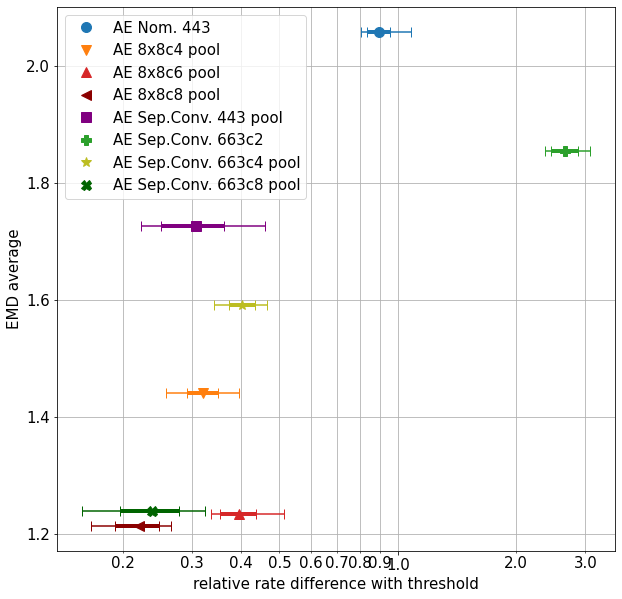

In [38]:
from matplotlib.ticker import FormatStrFormatter
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
for name in summary_algos:
    perf = average_perf[name]
    perf_err = rms_perf[name]
    perf_min = min_perf[name]
    perf_max = max_perf[name]
    nflops = nflops_ratio[name]
    #plt.errorbar(nflops, perf, yerr=np.array([[perf-perf_min ,perf_max-perf]]).T, color=colors[name], capsize=5)
    #plt.errorbar(nflops, perf, yerr=np.array([[perf_err ,perf_err]]).T, color=colors[name], capsize=5, lw=4)
    plt.plot(nflops, perf, markers[name], markersize=10, color=colors[name], label=legends[name])
ax = plt.gca()
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
plt.xlabel('flops ratio to nominal')
plt.ylabel('relative rate difference with threshold')
plt.grid(True, which='both')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
for name in summary_algos:
    perf = average_perf[name]
    perf_err = rms_perf[name]
    perf_min = min_perf[name]
    perf_max = max_perf[name]
    emd = emd_avg[name]
    plt.errorbar(perf, emd, xerr=np.array([[perf-perf_min ,perf_max-perf]]).T, color=colors[name], capsize=5)
    plt.errorbar(perf, emd, xerr=np.array([[perf_err ,perf_err]]).T, color=colors[name], capsize=5, lw=4)
    plt.plot(perf, emd, markers[name], markersize=10, color=colors[name], label=legends[name])
ax = plt.gca()
ax.set_xscale('log')
plt.tick_params(axis='x', which='minor')
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
plt.xlabel('relative rate difference with threshold')
plt.ylabel('EMD average')
plt.grid(True, which='both')
plt.legend()
plt.show()